In [19]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)
    
    display(HTML('<img src onerror="{}" style="display:none">'.format(script)))

In [20]:
set_background("green")
from ipynb.fs.full.kernels import *
from ipynb.fs.full.misc import plot_fig
#from ipynb.fs.full.com_dynamics import *;

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
	
def getPressure(rho, k, n):
	"""
	Equation of State
	rho   vector of densities
	k     equation of state constant
	n     polytropic index
	P     pressure
	"""
	
	P = k * rho**(1+1/n)
	return P
	

In [22]:
def getPairwiseSeparations(ri, rj):
    """ Just finds Cartesian Pairwise Separations between 2 points. 
    ri is an M x 3 matrix of positions, 
    rj    is an N x 3 matrix of positions 
    returns dx, dy, dz   are M x N matrices of separations. """
    M = ri.shape[0]
    N = rj.shape[0]
    rix = ri[:,0].reshape((M,1)) # positions ri = (x,y,z)
    riy = ri[:,1].reshape((M,1))
    riz = ri[:,2].reshape((M,1))
    rjx = rj[:,0].reshape((N,1)) # other set of points positions rj = (x,y,z)
    rjy = rj[:,1].reshape((N,1))
    rjz = rj[:,2].reshape((N,1))
    return rix - rjx.T , riy - rjy.T, riz - rjz.T # (dx, dy, dz) # return matrices that store all pairwise particle separations: r_i - r_j

def getDensity(r, pos, m, h , tag="gaussian"):
    """ Reconstruct the density at any location based on the sph points.
            r     is an M x 3 matrix of sampling locations
            pos   is an N x 3 matrix of SPH particle positions
          
          dx, dy, dz are all M x N matrices. (Seperations). 
          - Sum over all particle interactions with the points to get the density at the locations in r.
          
          m = particle mass, h = smoothing length """
    M = r.shape[0]
    dx, dy, dz = getPairwiseSeparations( r, pos );
    w = W(dx, dy, dz, h,tag=tag)
    rho = np.sum( m * w, 1 ).reshape((M,1)) # (56)
    return rho

In [23]:
def getAcc( pos, vel, m, h, k, n, lmbda, nu,tag="gaussian" ):
	"""
	Calculate the acceleration on each SPH particle
	pos   is an N x 3 matrix of positions
	vel   is an N x 3 matrix of velocities
	m     is the particle mass
	h     is the smoothing length
	k     equation of state constant
	n     polytropic index
	lmbda external force constant
	nu    viscosity
	a     is N x 3 matrix of accelerations
	"""
	
	N = pos.shape[0]
	
	# Calculate densities at the position of the particles
	rho = getDensity( pos, pos, m, h ,tag=tag)
	
	# Get the pressures
	P = getPressure(rho, k, n)
	
	# Get pairwise distances and gradients
	dx, dy, dz = getPairwiseSeparations( pos, pos )
	dWx, dWy, dWz = gradW( dx, dy, dz, h ,tag=tag)
	
	# Add Pressure contribution to accelerations
	ax = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWx, 1).reshape((N,1))
	ay = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWy, 1).reshape((N,1))
	az = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWz, 1).reshape((N,1))
	
	a = np.hstack((ax,ay,az))
	#print("a",a[0])
	a -= lmbda * pos
	#print("lmbda",a[0])
	# Add viscosity
	a -= nu * vel
	#print("vel",a[0])
	return a

In [24]:
def save(self, timestep, move=False,filename="single-star-Nov20"):
    # save data to output files
    loc = "data/" + filename + "/initialization/"
    if not os.path.exists(loc):
        os.makedirs(loc)
    np.savetxt(loc+'pos_'+str(timestep)+'.csv', np.asarray(self.pos))
    np.savetxt(loc+'vel_'+str(timestep)+'.csv', np.asarray(self.vel)) 
    np.savetxt(loc+'acc_'+str(timestep)+'.csv', np.asarray(self.acc)) 
    np.savetxt(loc+'rho_'+str(timestep)+'.csv', np.asarray(self.pos)) 
import os

In [25]:
class NS_:
    def __init__(self, name, mass = 1, radius = 13, num_points = 300,init_plot_filename = "file",h_init=0.5, nu=1,lagrange_tag = "vanilla",kernel_type="wendland_2",eta=0.01,clmbda=1, dt = 0.0001 ,tEnd = 0.005,test=False,plot_initialized_star=True,prt=False):
        """ 
        NEUTRON STAR OBJECT ATTRIBUTES
        tag, mass, radius, m (point mass), num_points, eos, lagrange_tag, kernel_type. eta, nu
        Point attributes: position (N x 3), vel (N x 3), acc (N x 3), density (N x 1), pressure (N x 1).        
        Initializes a NS object.
        """
        self.plot_init=plot_initialized_star
        h = None
        # Simulation parameters
        R = radius
        N         = num_points    # Number of particles
        t         = 0      # current time of the simulation
        tEnd      = 5     # time at which simulation ends
        dt        = 0.05   # timestep
        M         = mass      # star mass
        if h == None:
            h = R/10 
        self.h = h
        # star radius
        # smoothing length
        k         = 100    # equation of state constant
        n         = 1      # polytropic index
        nu        = 1      # damping
        lmbda = 2*k*(1+n)*np.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2  # ~ 2.01
        self.lmbda=lmbda
        self.name = name # "Name" of the star, just a string for identification
        self.radius = radius # star radius in km ======= Star properties
        self.mass = mass # star mass in solar Masses 
        self.num_points = num_points # number of SPH points modeling the star
        self.com = [0,0,0] # center of mass is initialized at the origin. ======= Star motion
        #self.pos, self.vel, self.acc = init_xva(self.num_points, R = self.radius)
        self.pos = np.random.randn(N,3)
        self.vel   = np.zeros(self.pos.shape)
        self.m = mass/self.num_points # each point has "mass" m in solar masses (maybe change later to baryon number)
        self.acc = getAcc( self.pos, self.vel, self.m, h, k, n, lmbda, nu ,tag=kernel_type)
        self.num_points = np.shape(self.pos)[0] # reset the number of points to match the initialized sphere
        self.points_position = np.copy(self.pos) # true position, this will be corrected when we move the center of mass. 
        self.kernel_type = kernel_type # Kernel used for determining particle density ====== Smoothing Length and Particle Density  ==  
        self.eta = eta # Multiplies the smoothing length based on particle density
        self.rho = getDensity(self.pos, self.pos, self.m, self.h,tag=kernel_type)
        #self.h = calculate_h(self) # Smoothing length depends on density of the particle.
        self.Gamma = 5/3
        self.Adot = np.zeros(self.rho.shape)
        self.A = np.zeros(self.rho.shape)
        self.c = None
        self.nu=1
        self.ltag=""
        self.kernel_type = kernel_type
        self.test_acc_data = {"acc": [], "dAdt": [],"visc":[],"pos":[],"rho":[],"grav":[],"Pressure":[],"(P - grav force)":[],"smoothing length":[],"Pos":[]}
        #========= INITIALIZATION STEP. Initialize star from Random points =====#
        if not test:
            print("Initializing...")
        r_start = self.pos[0][0]
        self.initialize(tEnd=tEnd,tag=kernel_type,plotRealTime=prt) # initialize the star
        return None

    def test(self,plot=False,test=True):
        plot_init =[]
        plot_init.append(self.points_position)
        self.initialization_notes = "none"
        if test:
            self.grav_test = None
        plot_init.append(self.pos)
        if test:
            zero=0
            self.test_acc_data['acc'].append(self.acc[0][0])
            #self.test_acc_data['vel'].append(self.vel[0][0])
            self.test_acc_data["pos"].append(zero)
            position = self.getPosition()
            self.test_acc_data["pos"].append(position[0][0])
            self.test_acc_data['dAdt'].append(zero)                
            self.test_acc_data['rho'].append(self.rho[0][0])
            self.test_acc_data["visc"].append(zero)
            self.test_acc_data["grav"].append(zero)
            self.test_acc_data["Pressure"].append(zero)
            self.test_acc_data["(P - grav force)"].append(zero)
            self.test_acc_data["smoothing length"].append(zero)
            if plot:
                print("plotting")
                plot_init.append(self.pos)
                data = plot_init
                plot_fig(data, "plot_test_NS" + self.kernel_type)
                print(init_plot_filename)
        return None

            #========================================================================#
                
    def save(self, timestep, move=False,filename="single-star-Nov20"):
        # save data to output files
        loc = "data/" + filename + "/initialization/"
        if not os.path.exists(loc):
            os.makedirs(loc)
        np.savetxt(loc+'pos_'+str(timestep)+'.csv', np.asarray(self.pos))
        if move:
            np.savetxt(loc+'com_'+str(timestep)+'.csv', np.asarray(self.com))
        np.savetxt(loc+'vel_'+str(timestep)+'.csv', np.asarray(self.vel)) 
        np.savetxt(loc+'acc_'+str(timestep)+'.csv', np.asarray(self.acc)) 
        np.savetxt(loc+'rho_'+str(timestep)+'.csv', np.asarray(self.pos)) 
        
    def initialize(self,tEnd = 5,plotRealTime = False,h = None,tag="gaussian",save=False,dt=None):
        """ SPH simulation """
        # Simulation parameters
        N         = self.num_points    # Number of particles
        t         = 0      # current time of the simulation
        # tEnd is the time at which simulation ends
        if dt== None:
            dt = 0.05   # timestep
        M = self.mass
        R = self.radius
        if h == None:
            h = R/10  # smoothing length
        k         = 100    # equation of state constant
        n         = 1      # polytropic index
        nu        = 1      # damping
        lmbda = 2*k*(1+n)*np.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2  # ~ 2.01
        m     = self.m                  # single particle mass
        # calculate initial gravitational accelerations
        Nt = int(np.ceil(tEnd/dt))# number of timesteps
        if self.plot_init:
            # prep figure
            fig = plt.figure(figsize=(4,5), dpi=80)
            grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
            ax1 = plt.subplot(grid[0:2,0])
            ax2 = plt.subplot(grid[2,0])
        rr = np.zeros((100,3))
        rlin = np.linspace(0,1,100)
        rr[:,0] =rlin
        rho_analytic = lmbda/(4*k) * (R**2 - rlin**2)
        if save:
            print("Timesteps:",Nt)
        # Simulation Main Loop
        for i in range(Nt):
            self.vel += self.acc * dt/2 # (1/2) kick
            self.pos += self.vel * dt # drift
            self.acc = getAcc( self.pos, self.vel, self.m, h, k, n, lmbda, nu ,tag=tag)# update accelerations
            self.vel += self.acc * dt/2# (1/2) kick
            t += dt # update time
            timestep=i
            self.rho = getDensity( self.pos, self.pos, self.m, self.h ,tag=tag) # get density for plotting
            if save:
                loc = "init_test_data/"+ tag+"_"+str(N)+"/"
                if not os.path.exists(loc):
                    os.makedirs(loc)
                np.savetxt(loc+'pos_'+str(timestep)+'.csv', np.asarray(self.pos))
                np.savetxt(loc+'vel_'+str(timestep)+'.csv', np.asarray(self.vel)) 
                np.savetxt(loc+'acc_'+str(timestep)+'.csv', np.asarray(self.acc)) 
                np.savetxt(loc+'rho_'+str(timestep)+'.csv', np.asarray(self.rho)) 
            # plot in real time
            if plotRealTime or (i == Nt-1):# or (i%10==0):
                self.test()
                if ((i == Nt-1) or plotRealTime) and self.plot_init and (i%100==0):
                    print("t=",t)
                    plt.sca(ax1)
                    plt.cla()
                    cval = np.minimum((self.rho-3)/3,1).flatten()
                    plt.scatter(self.pos[:,0],self.pos[:,1], c=cval, cmap=plt.cm.autumn, s=5, alpha=0.5)
                    ax1.set(xlim=(-2*R, 2*R), ylim=(-2*R, 2*R))
                    ax1.set_aspect('equal', 'box')
                    #ax1.set_xticks([-1,0,1])
                    #ax1.set_yticks([-1,0,1])
                    ax1.set_facecolor('grey')
                    ax1.set_facecolor((.1,.1,.1))
                    plt.sca(ax2)
                    plt.cla()
                    ax2.set(xlim=(0, R), ylim=(0, 3))
                    ax2.set_aspect(0.1)
                    plt.plot(rlin, rho_analytic, color='gray', linewidth=2)
                    rho_radial = getDensity( rr, self.pos, self.m, self.h,tag=tag )
                    plt.plot(rlin, rho_radial, color='blue')
                    plt.pause(0.001)
        if save: 
            INFO_OUT = "\n\nSingle Star Initialization Run \nnumber of Points: "+str(N)+"\nradius: "+str(R)
            INFO_OUT += "\ntimestep: "+str(dt) + "\ntotal time:"+str(tEnd) + "\nNumber of timesteps: "+str(Nt)
            INFO_OUT +="\npoint mass: "+str(self.m)+" solar masses"+"\nkernel type: "+str(self.name)+ "\nFor more info on kernel type, smoothing lengths, see the sph imports file."
            with open(loc + 'info.txt', 'w') as f:
                f.write(INFO_OUT) 

        # add labels/legend
        if self.plot_init:
            plt.sca(ax2)
            plt.xlabel('radius')
            plt.ylabel('density')

            # Save figure
            plt.savefig('sph.png',dpi=240)
            plt.show()
        print("R = ",R, ", M=", M)    
        return 0   
        
    def update_star_new(self,plotRealTime = False,h = None,tag="gaussian",save=False,dt=None,COM_POSITIONS = [],params=None):
        """ SPH simulation """
        # Simulation parameters
        tEnd = 0.8 # tEnd is the time at which simulation ends
        Nt = len(COM_POSITIONS) # number of timesteps
        dt        =  tEnd/Nt # timestep
        N         = self.num_points    # Number of particles
        t         = 0      # current time of the simulation
        M = self.mass
        R = self.radius
        if h == None:
            h = R/10  # approximate smoothing length
        if params==None:
            k         = 100    # equation of state constant
            n         = 1      # polytropic index
            nu        = 1      # damping
        else:
            k = params["k"]
            n = params["n"]
            nu = params["nu"]
        lmbda = 2*k*(1+n)*np.pi**(-3/(2*n)) * (M*gamma(5/2+n)/R**3/gamma(1+n))**(1/n) / R**2  # ~ 2.01
        m     = self.m                  # single particle mass
        # calculate initial gravitational accelerations
        
        if self.plot_init:
            # prep figure
            fig = plt.figure(figsize=(4,5), dpi=80)
            grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
            ax1 = plt.subplot(grid[0:2,0])
            ax2 = plt.subplot(grid[2,0])
        rr = np.zeros((100,3))
        rlin = np.linspace(0,1,100)
        rr[:,0] =rlin
        rho_analytic = lmbda/(4*k) * (R**2 - rlin**2)
        if save:
            print("Timesteps:",Nt)
        # Simulation Main Loop
        for i in range(Nt):
            self.test()
            #print(self.com)
            position = self.getPosition()
            self.com = COM_POSITIONS[i]
            self.vel += self.acc * dt/2 # (1/2) kick
            self.pos += self.vel * dt # drift
            self.acc = getAcc( position, self.vel, self.m, h, k, n, lmbda, nu,tag=tag )# update accelerations
            self.vel += self.acc * dt/2# (1/2) kick
            t += dt # update time
            timestep=i
            self.rho = getDensity( position, position, self.m, self.h,tag=tag ) # get density for plotting
            if save:
                loc = "init_test_data/"+ tag+"_"+str(N)+"/"
                if not os.path.exists(loc):
                    os.makedirs(loc)
                np.savetxt(loc+'pos_'+str(timestep)+'.csv', np.asarray(self.pos))
                np.savetxt(loc+'vel_'+str(timestep)+'.csv', np.asarray(self.vel)) 
                np.savetxt(loc+'acc_'+str(timestep)+'.csv', np.asarray(self.acc)) 
                np.savetxt(loc+'rho_'+str(timestep)+'.csv', np.asarray(self.rho)) 
            # plot in real time
            if plotRealTime or (i == Nt-1) or (i%100==0):
                if ((i == Nt-1) or plotRealTime) and self.plot_init and (i%25==0):
                    print("t=",t)
                    plt.sca(ax1)
                    plt.cla()
                    cval = np.minimum((self.rho-3)/3,1).flatten()
                    plt.scatter(self.position[:,0],self.position[:,1], c=cval, cmap=plt.cm.autumn, s=2, alpha=0.5)
                    ax1.set(xlim=(-2*R, 2*R), ylim=(-2*R, 2*R))
                    ax1.set_aspect('equal', 'box')
                    #ax1.set_xticks([-1,0,1])
                    #ax1.set_yticks([-1,0,1])
                    ax1.set_facecolor('grey')
                    plt.sca(ax2)
                    plt.cla()
                    ax2.set(xlim=(0, R), ylim=(0, 3))
                    ax2.set_aspect(0.1)
                    plt.plot(rlin, rho_analytic, color='gray', linewidth=2)
                    rho_radial = getDensity( rr, self.pos, self.m, self.h )
                    plt.plot(rlin, rho_radial, color='blue')
                    plt.pause(0.001)
        if save: 
            INFO_OUT = "\n\nSingle Star Initialization Run \nnumber of Points: "+str(N)+"\nradius: "+str(R)
            INFO_OUT += "\ntimestep: "+str(dt) + "\ntotal time:"+str(tEnd) + "\nNumber of timesteps: "+str(Nt)
            INFO_OUT +="\npoint mass: "+str(self.m)+" solar masses"+"\nkernel type: "+str(self.name)+ "\nFor more info on kernel type, smoothing lengths, see the sph imports file."
            with open(loc + 'info.txt', 'w') as f:
                f.write(INFO_OUT) 

        # add labels/legend
        if self.plot_init:
            plt.sca(ax2)
            plt.xlabel('radius')
            plt.ylabel('density')

            # Save figure
            plt.savefig('sph.png',dpi=240)
            plt.show()
        print("R = ",R, ", M=", M,", k=",k,)    
        return 0        

    def update_star(self,dt=None):
        if dt == None:
            dt = calculate_tstep(self)
        self.A = self.A + dt/2*self.Adot # update A
        self.h = calculate_h(self)
        self.pos += self.vel * dt/2 # particle motion
        self.vel += self.acc * dt/2 # (1/2) kick # adds acceleration
        self.acc = getAcc(self, test=self.test) # get new Nx3 matrix of accelerations based on new pos,v
        self.vel += self.acc * dt/2 # (1/2) kick 
        self.pos += self.vel * dt/2 # particle motion
        positions = self.getPosition()
        self.rho = getDensity(positions, positions, self.m, self.h) # get updated density for each point based on m, h. 
        self.position = positions
        return self.pos
        
    def combine(self, star): 
        star1_pos = self.getPosition()
        star2_pos = star.getPosition()
        self.vel = np.concatenate((self.vel,star.vel), axis = 0)
        self.pos = np.concatenate((self.pos,star.pos), axis = 0)
        self.position = np.concatenate((star1_pos,star2_pos), axis = 0)
        self.acc = np.concatenate((self.acc,star.acc), axis = 0)
        self.rho = getDensity(self.position, self.position, self.m, self.h)
        #self.h = np.concatenate((self.h,star.h), axis = 0)
        self.num_points = self.num_points + star.num_points
        if self.m != star.m: 
            raise SyntaxError("star.m must be the same!")
        self.com = [self.com, star.com]
        return self
    
    def getPosition(self):
        """ 
        Returns the true positions of all the points 
        in the star, which are corrcted for the center of mass location.
        """
        position = np.copy(self.pos)
        COM = self.com
        # print("CENT", COM)
        if np.size(COM[0]) > 2:
            i = int(self.num_points/2)
            position[:i,0] += COM[0][0]
            position[:i,1] += COM[0][1]
            position[:i,2] += COM[0][2]
            position[i+1:,0] += COM[1][0]
            position[i+1:,1] += COM[1][1]
            position[i+1:,2] += COM[1][2]
        else:
            position[:,0] += COM[0]
            position[:,1] += COM[1]
            position[:,2] += COM[2]
        self.position  = position # track the true particle locations
        return position
    
    def move_com(self, com_new,com2 = [None]): 
        """
        Takes in new coordinates of the center of mass of the star in km. 
        Changes the location of the star's center of mass.
        """
        if com2[0] == None:
            self.com = com_new
        else:
            self.com = [com_new,com2]

    def __str__(self):
        return "\nSTAR OBJECT. Name: '" + self.name + "', Mass: " + str(self.mass) + " SMs, Radius: " # + str(self.radius) + " km" 
    def get_relative_position(self):
        """  This function returns an N x 3 array of the star's points positions relative to the center of mass """
        return self.pos
    def get_velocity(self):
        """ This function returns the star's velocity.    """
        return self.vel
    def get_mass(self):
        """ This function returns the star's overall mass . """
        return self.mass

In [26]:
star1 = NS_("mystar", mass = 1, radius = 13, num_points = 400,plot_initialized_star=False,kernel_type="gaussian")

Initializing...
R =  13 , M= 1


t= 4.99999999999999


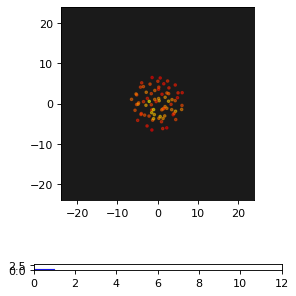

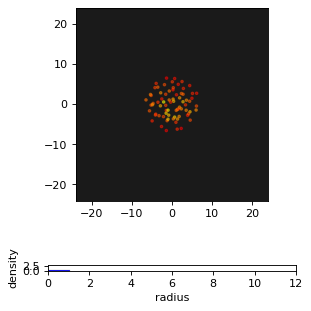

R =  12 , M= 2 , k= 100


0

In [22]:
# "cubic_spline"
#main(npts=75,R=12,tag="cubic_spline")

t= 4.99999999999999


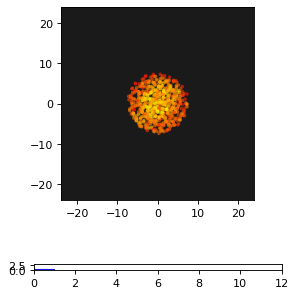

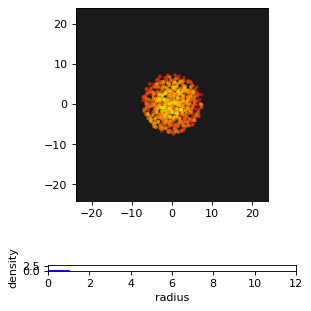

R =  12 , M= 2 , k= 100


0

In [23]:
# "wendland_2"
#main(npts=600,R=12,tag="cubic_spline")

t= 4.99999999999999


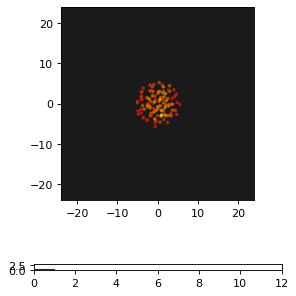

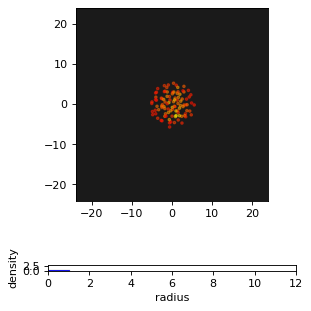

R =  12 , M= 2 , k= 100


0

In [24]:
# gaussian kernel (me)
#main(npts=100,R=12)

t= 4.99999999999999


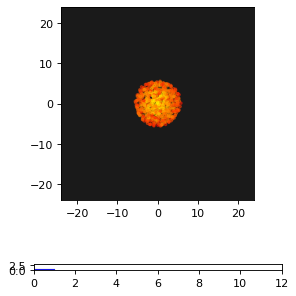

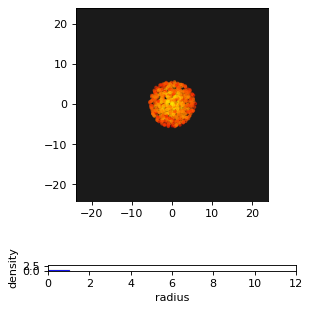

R =  12 , M= 2 , k= 100


0

In [25]:
# gaussian kernel (medium)
#main(npts=600,R=12)